In [14]:
import sys
import os
from os import sep
from os.path import dirname, realpath
from pathlib import Path
from itertools import product
import logging

def get_cwd(fname, subdir, crunch_dir=realpath(Path.home()) +sep +'crunch' +sep):
    """
    Convenience function to make a directory string for the current file based on inputs.
    Jupyter Notebook in Anaconda invokes the Python interpreter in Anaconda's subdirectory
    which sis why changing sys.argv[0] is necessary. In the future a better way to do this
    should be preferred..
    """
    return crunch_dir +subdir +fname

def fix_path(cwd):
    """
    Convenience function to fix argv and python path so that jupyter notebook can run the same as
    any script in crunch.
    """
    sys.argv[0] = cwd
    module_path = os.path.abspath(os.path.join('..'))
    if module_path not in sys.path:
        sys.path.append(module_path)

fix_path(get_cwd('pattern_eda.ipynb', 'mutate' +sep))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numba import jit, vectorize, float64, uint
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.piecewise import PiecewiseAggregateApproximation
from tslearn.piecewise import SymbolicAggregateApproximation, OneD_SymbolicAggregateApproximation
from scipy.stats import zscore
from sortedcontainers import SortedList, SortedSet 

from ipywidgets import interact, interactive, fixed
from IPython.display import display

pd.set_option("display.max_rows", 100)
pd.set_option('display.max_columns', 50)

from common_util import DT_HOURLY_FREQ, DT_CAL_DAILY_FREQ, DT_BIZ_DAILY_FREQ, get_custom_biz_freq, get_custom_biz_freq_df, query_df, search_df, chained_filter, benchmark
from common_util import MUTATE_DIR, load_json, outer_join, left_join, count_nn_df, count_nz_df, count_nn_nz_df, pairwise, cust_count, dti_to_ymd
from data.data_api import DataAPI
from data.access_util import col_subsetters as cs
from mutate.common import dum
from recon.viz import *

## Load Data

In [15]:
logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)

date_range = {
    'id': ('lt', 2018)
}

search_terms = {
    'stage': 'raw',
    'raw_cat': 'us_equity_index'
}
price_dfs = {}
for rec, price_df in DataAPI.generate(search_terms):
    price_dfs[rec.root] = price_df.loc[search_df(price_df, date_range)]
logging.info('price data loaded')

INFO:root:price data loaded


In [16]:
search_terms = {
    'stage': 'mutate',
    'mutate_type': 'thresh',
    'raw_cat': 'us_equity_index'
}
thresh_dfs = {}
for rec, price_df in DataAPI.generate(search_terms):
    thresh_dfs[rec.root] = price_df.loc[search_df(price_df, date_range)]
logging.info('thresh data loaded')

INFO:root:thresh data loaded


In [17]:
search_terms = {
    'stage': 'mutate',
    'mutate_type': 'normalize',
    'raw_cat': 'us_equity_index'
}
normalize_dfs = {key: {} for key in price_dfs.keys()}
for rec, norm_df in DataAPI.generate(search_terms):
    normalize_dfs[rec.root][rec.desc] = norm_df.loc[search_df(norm_df, date_range)]
logging.info('normalize data loaded')

INFO:root:normalize data loaded


In [18]:
assets = list(price_dfs.keys())
pattern_info = load_json('pattern_thresh.json', dir_path=MUTATE_DIR)

# Sandbox

## Function Defs

In [19]:
def get_thresh_pattern_series(pattern_info):
    """
    Return mapping of return columns to lists of candidate threshold columns.
    """
    tup_str = lambda c: '_'.join([c[0], c[1], c[2], c[3], sc, c[4]])

    all_src = pattern_info['src']
    fast_slow = pattern_info['fast_slow']
    thresh_type = pattern_info['thresh_type']
    time_hor = pattern_info['time_hor']
    shift_code = pattern_info['shift_code']
    pattern_trans = pattern_info['pattern_trans']
    
    thresh_pattern_cols = []
    for sc in shift_code:
        return list(map(tup_str, product(all_src, fast_slow, thresh_type, time_hor, pattern_trans[sc])))

### Normalization

In [20]:
def dayznorm(df):
    cust = get_custom_biz_freq(df)
    return df.groupby(pd.Grouper(freq=cust)).transform(zscore)

def dayznorm_b(df):
    return df.groupby(pd.Grouper(freq=DT_BIZ_DAILY_FREQ)).transform(zscore)

In [21]:
def dayminmaxnorm(df):
    cust = get_custom_biz_freq(df)
    bipolar_mm_transform = lambda ser: 2 * ((ser-ser.min()) / (ser.max()-ser.min())) - 1
    return df.groupby(pd.Grouper(freq=cust)).transform(bipolar_mm_transform)

### Segmentation

In [22]:
DEFAULT_PATTERN_SIZE = 3
DEFAULT_PIP_METHOD = 'vd'

def vd(l, r, point):
    l_x, l_y = l
    r_x, r_y = r
    point_x, point_y = point

    return abs(((l_y + (r_y - l_y) * (point_x - l_x) / (r_x - l_x) - point_y)) * (r_x - l_x))

In [23]:
def pip_df(df, pattern_size=DEFAULT_PATTERN_SIZE, method=DEFAULT_PIP_METHOD):
    """
    Perceptually Important Points: Choose points by distance to points already in pattern.
    
    This implementation assumes all points are equally spaced.
    """
    distance_fun = {
        'ed': None,    # euclidean distance
        'pd': None,    # perpendicular distance to joining line
        'vd': vd       # vertical distance to joining line
    }.get(method)

    def get_max_dist_point(ser, left, right, dist_fun=distance_fun):
        """
        Loop through all points in ser from left to right ilocs,
        get max point and return it's iloc.
        """
        if (left == right):
            raise ValueError('Zero Division')
        
        md, md_iloc = 0, 0
        left_xy = (left, ser.iloc[left])
        right_xy = (right, ser.iloc[right])

        for point in ser.iloc[left:right].iteritems():
            point_xy = (ser.index.get_loc(point[0]), point[1])
            dist = dist_fun(left_xy, right_xy, point_xy)
            if (md < dist):
                md = dist
                md_iloc = point_xy[0]

        return md, md_iloc

    def get_next_point(ser, pattern):
        md, md_iloc = 0, 0

        for l, r in pairwise(pattern):
            dist, iloc = get_max_dist_point(ser, l, r)
            if (md < dist):
                md = dist
                md_iloc = iloc

        return md_iloc

    def pip_ser(ser, pattern_size=pattern_size):
        if (len(ser) > pattern_size):
            pattern_iloc = SortedSet([0, len(ser)-1])
            while (len(pattern_iloc) < pattern_size):
                next_point = get_next_point(ser, pattern_iloc)
                pattern_iloc.add(next_point)
            pattern = ser.iloc[pattern_iloc]

        elif (len(ser) == pattern_size):
            pattern = ser
        else:
            pattern = ser
        return pattern
    
    # TODO - HANDLE ALL DAYS WITH LESS THAN pattern_size number of points
    # Options:
    #     - greater: run pip
    #     - equal: no change or drop
    #     - less than: drop
    # Set distance function to use

    cust = get_custom_biz_freq(df)
    return df.groupby(pd.Grouper(freq=cust)).transform(pip_ser)

In [11]:
def paa_df(df, pattern_size=DEFAULT_PATTERN_SIZE):
    """
    Piecewise Aggregate Approximation: Fancy name for taking the average of each of n equally spaced segments.
    """
    def paa_ser(ser, pattern_size=pattern_size):
        if (len(ser) > pattern_size):
            pattern_iloc = SortedSet([0, len(ser)-1])
            
        elif (len(ser) == pattern_size):
            pattern = ser
        else:
            pattern = ser
        return pattern

    cust = get_custom_biz_freq(df)
    return df.groupby(pd.Grouper(freq=cust)).transform(paa)

In [12]:
def piecewise_linear_approximation(df):
    pass

### Symbolization

In [13]:
def sax_df(df, num_seg, num_symbols):
    """
    Return symbolic aggregate approximation of ser.
    """
    sax = SymbolicAggregateApproximation(n_segments=num_seg, alphabet_size_avg=num_symbols)
    cust = get_custom_biz_freq(df)
    res_df = sax.inverse_transform(sax.fit_transform(df.values))
#     res_df = df.groupby(pd.Grouper(freq=cust)).transform(lambda s: sax.fit_transform(s.values))
#     res_df = df.groupby(pd.Grouper(freq=cust)).transform(lambda s: sax.inverse_transform(sax.fit_transform(s.values)))
    return res_df

In [14]:
def one_dimensional_sax_ser(ser, num_seg, num_symbols, num_slope_symbols):
    """
    Return one dimensional symbolic aggregate approximation of ser.
    """
    one_d_sax = OneD_SymbolicAggregateApproximation(n_segments=num_seg, alphabet_size_avg=num_symbols,
                                                    alphabet_size_slope=num_slope_symbols)
    one_d_sax_dataset_inv = one_d_sax.inverse_transform(one_d_sax.fit_transform(dataset))
    return one_d_sax_dataset_inv

## Select and Modify

### Select Starting Columns

In [15]:
thresh_cols = get_thresh_pattern_series(pattern_info)
pba_cols = chained_filter(price_dfs[assets[1]].columns, [cs['#pba']['ohlc']])
vol_cols = chained_filter(price_dfs[assets[1]].columns, [cs['#vol']['ohlc']])
pba_vol_cols = pba_cols + vol_cols

In [16]:
thresh_df = thresh_dfs[assets[1]].loc[:, thresh_cols]
pba_df = price_dfs[assets[1]].loc[:, pba_cols]
vol_df = price_dfs[assets[1]].loc[:, vol_cols]
pba_vol_df = price_dfs[assets[1]].loc[:, pba_vol_cols]

In [17]:
pba_vol_cust, pba_vol_count_df = cust_count(pba_vol_df)
pba_vol_count_df.apply(pd.Series.value_counts)

,pba_open,pba_high,pba_low,pba_close,pba_avgPrice,vol_open,vol_high,vol_low,vol_close,vol_avgPrice
0,204.0,204.0,204.0,204.0,204.0,205,205,205,205,205
1,1.0,1.0,1.0,1.0,1.0,2,2,2,2,2
2,7.0,7.0,7.0,7.0,7.0,7,7,7,7,7
3,5.0,5.0,5.0,5.0,5.0,7,7,7,7,7
4,5.0,5.0,5.0,5.0,5.0,6,6,6,6,6
5,46.0,46.0,46.0,46.0,46.0,44,44,44,44,44
6,15.0,15.0,15.0,15.0,15.0,33,33,33,33,33
7,18.0,18.0,18.0,18.0,18.0,1353,1353,1353,1353,1353
8,4890.0,4890.0,4890.0,4890.0,4890.0,3106,3106,3106,3106,3106
9,26.0,26.0,26.0,26.0,26.0,22,22,22,22,22


In [18]:
pba_tdf = thresh_df['pba_oc_spread_fth_of_xact']
pba_tdf_cust, pba_tdf_count_df = cust_count(pba_tdf)
pba_tdf_count_df.value_counts()

8    4890
0     203
5      46
9      26
7      18
6      15
2       7
3       5
4       5
1       1
Name: pba_oc_spread_fth_of_xact, dtype: int64

In [19]:
vol_tdf = thresh_df['vol_oc_spread_fth_of_xact']
vol_tdf_cust, vol_tdf_count_df = cust_count(vol_tdf)
vol_tdf_count_df.value_counts()

8     3106
7     1353
14     414
0      204
5       44
6       33
9       22
13      14
3        7
2        7
4        6
11       4
1        2
Name: vol_oc_spread_fth_of_xact, dtype: int64

### Normalization

Day Z Score Normalization

In [23]:
dzn_thresh_cols_df = dayznorm(thresh_cols_df.dropna())
dzn_price_vol_cols_df = dayznorm(price_vol_cols_df.dropna())

NameError: name 'thresh_cols_df' is not defined

day Min Max Normalization

In [17]:
dmx_thresh_cols_df = dayminmaxnorm(thresh_cols_df.dropna())
dmx_price_vol_cols_df = dayminmaxnorm(price_vol_cols_df.dropna())

In [25]:
for key in normalize_dfs[assets[1]].keys():
    norm_df = normalize_dfs[assets[1]][key]
    print(key)
    cust, count_df = cust_count(norm_df)
    print(count_df.apply(pd.Series.value_counts))

raw_pba_dzn
   pba_open  pba_high  pba_low  pba_close  pba_avgPrice
8      4890      4890     4890       4890          4890
0       204       204      204        204           204
5        46        46       46         46            46
9        26        26       26         26            26
7        18        18       18         18            18
6        15        15       15         15            15
2         7         7        7          7             7
3         5         5        5          5             5
4         5         5        5          5             5
raw_pba_dmx
   pba_open  pba_high  pba_low  pba_close  pba_avgPrice
8      4890      4890     4890       4890          4890
0       204       204      204        204           204
5        46        46       46         46            46
9        26        26       26         26            26
7        18        18       18         18            18
6        15        15       15         15            15
2         7         7   

    pba_oc_spread_fth_of_xact  pba_oc_spread_fth_of_xwhole  \
0                       203.0                        203.0   
1                         1.0                          1.0   
2                         7.0                          7.0   
3                         5.0                          5.0   
4                         5.0                          5.0   
5                        46.0                         46.0   
6                        15.0                         15.0   
7                        18.0                         18.0   
8                      4890.0                       4890.0   
9                        26.0                         26.0   
10                        NaN                          NaN   
11                        NaN                          NaN   
12                        NaN                          NaN   
13                        NaN                          NaN   
14                        NaN                          NaN   

    pba

### Segmentation

Perceptually Important Points (PIP)

In [18]:
# # pip_thresh_dzn5 = pip_df(dzn_thresh_cols_df)
# with benchmark('price_vol pip') as bprice_vol_cols:
#     pip_price_vol_dzn5 = pip_df(dzn_price_vol_cols_df.loc[:, ['pba_avgPrice', 'vol_avgPrice']])
#     print(b)

Piecewise Aggregate Approximation (PAA)

Piecewise Linear Approximation (PLA)

None (Drop days under the most common day vector length, shorten those longer)

In [30]:
cust, dzn_price_count_df = cust_count(price_vol_cols_df)
price_vol_cols_df.groupby(pd.Grouper(freq=cust)).transform(zscore)

,pba_open,pba_high,pba_low,pba_close,pba_avgPrice,vol_open,vol_high,vol_low,vol_close,vol_avgPrice
id,,,,,,,,,,
1998-01-01 01:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-01-01 02:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-01-01 03:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-01-01 04:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-01-01 05:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-01-01 06:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-01-01 07:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-01-01 08:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-01-01 09:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
cust, dzn_price_count_df = cust_count(dzn_price_vol_cols_df)

In [28]:
xdf.groupby(pd.Grouper(freq=DT_BIZ_DAILY_FREQ)).count()

,pba_open,pba_high,pba_low,pba_close,pba_avgPrice,vol_open,vol_high,vol_low,vol_close,vol_avgPrice
id,,,,,,,,,,
1998-01-01 00:00:00+00:00,0,0,0,0,0,0,0,0,0,0
1998-01-02 00:00:00+00:00,0,0,0,0,0,0,0,0,0,0
1998-01-05 00:00:00+00:00,0,0,0,0,0,0,0,0,0,0
1998-01-06 00:00:00+00:00,0,0,0,0,0,0,0,0,0,0
1998-01-07 00:00:00+00:00,0,0,0,0,0,0,0,0,0,0
1998-01-08 00:00:00+00:00,0,0,0,0,0,0,0,0,0,0
1998-01-09 00:00:00+00:00,0,0,0,0,0,0,0,0,0,0
1998-01-12 00:00:00+00:00,0,0,0,0,0,0,0,0,0,0
1998-01-13 00:00:00+00:00,0,0,0,0,0,0,0,0,0,0


In [29]:
ex_df = dzn_price_count_df[['pba_avgPrice']]
cust = get_custom_biz_freq(ex_df)
count_df = ex_df.groupby(pd.Grouper(freq=cust)).count()
count_df.index = count_df.index.strftime("%Y-%m-%d")

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'

In [26]:
dzn_price_count_df['pba_avgPrice'].value_counts()

8    3536
7    1354
5      49
6      31
9      20
3       7
2       7
4       6
Name: pba_avgPrice, dtype: int64

In [27]:
dzn_price_count_df['vol_avgPrice'].value_counts()

8    3536
7    1354
5      49
6      31
9      20
3       7
2       7
4       6
Name: vol_avgPrice, dtype: int64

### Symbolization

Symbolic Aggregate Approximation (SAX)

In [ ]:
def sax_df(df, num_seg, num_symbols):
    """
    Return symbolic aggregate approximation of ser.
    """
    sax = SymbolicAggregateApproximation(n_segments=num_seg, alphabet_size_avg=num_symbols)
    cust = get_custom_biz_freq(df)
    res_df = sax.inverse_transform(sax.fit_transform(df.values))
#     res_df = df.groupby(pd.Grouper(freq=cust)).transform(lambda s: sax.fit_transform(s.values))
#     res_df = df.groupby(pd.Grouper(freq=cust)).transform(lambda s: sax.inverse_transform(sax.fit_transform(s.values)))
    return res_df

In [20]:
def sax_td_df(df, num_seg, num_sym):
    """
    Symbolic Aggregate Approximation (SAX) with Trend Distance.
    """
    
    

In [21]:
from numba import uint
from scipy.stats import linregress

In [22]:
def sax_1d_df(df, num_seg, num_sym, num_slp):
    """
    One Dimensional Symbolic Aggregate Approximation (1d-SAX).

    1. Divide a time series into num_seg segments
    2. Compute the average of the time series on each segment
    3. Quantize the average values into a symbol from an alphabet of size num_sym
    4. Quantize the slope values into a symbol from an alphabet of size num_slp
    """
#     @vectorize([float64(float64, uint, uint, uint)], nopython=True)
#     def sax_1d_arr(arr, num_seg, num_sym, num_slp):
#         x_locs = np.arange(start=0, stop=arr.size, step=1)
#         x_segs = np.array_split(x_locs, num_seg)
#         y_segs = np.array_split(arr, num_seg)
#         means = np.mean(y_segs)
#         linreg = np.polyfit(x_locs, y_segs, 1)
#         print(arr)
#         print(x_locs)
#         print(y_segs)
#         print(means)
#         print(linreg)
#         return means
        
        
    def sax_1d_ser(ser, num_seg=num_seg, num_sym=num_sym, num_slp=num_slp):
        print(ser.values)
        return None#sax_1d_arr(ser.values, num_seg, num_sym, num_slp)

    cust = get_custom_biz_freq(df)
    return df.groupby(pd.Grouper(freq=cust)).transform(sax_1d_ser)

In [23]:
saxd = sax_1d_df(dzn_price_vol_cols_df.loc[:, 'pba_avgPrice'], 3, 8, 8)

[-0.9878487   0.27502164  1.02977971  0.95219973 -1.67765183  0.40849946]
[-0.18597787  1.1754446   1.29104303  0.04767854 -1.48381787 -0.84437043]
[ 1.79034382  0.81219669  0.00461087 -0.98847677 -0.12255453 -0.03262636
 -1.46349371]
[ 1.56818987  0.61045682 -0.21535534 -0.66980548 -1.29348587]
[ 1.55680734 -0.96739763  1.17676416 -0.30906918 -0.94313955  0.49753807
 -1.01150322]
[ 1.4182213   0.85570495  0.46822363 -0.07035748  0.01783384 -0.88936217
 -1.80026408]
[-1.98834675 -0.82647364  0.23666667  0.34873632  0.94384784  0.15874083
  1.12682873]
[-0.90846408 -0.81516686 -1.07894306  0.16103145 -0.19582638  1.06058698
  1.77678194]
[ 0.2775185  -0.43182459 -1.02965983 -1.11857896 -0.14003773  0.37797129
  2.06461132]
[ 1.01121188  0.24805137  1.85166984 -0.6833626  -0.78301965 -0.65665249
 -0.98789835]
[-1.7374835  -1.29341283  0.06619129  0.68265674  1.01483205  0.58345728
  0.68375896]
[-1.28168287 -0.85047032 -0.29215457 -0.11671234 -0.19874651  0.76064098
  1.97912565]
[ 1.185

 -2.20398852]
[ 1.48591419  1.27656453  0.34147151 -1.16627219 -1.06154965 -0.73383459
 -0.1422938 ]
[-0.73424657  0.3481726   1.46487916  0.65409399  0.72672596 -0.90351565
 -1.5561095 ]
[-0.63689141 -1.12179157 -0.76860636 -0.45491841 -0.02003004  1.37636028
  1.62587751]
[ 0.36049169 -0.81203319  0.67409504 -0.4398811   0.66227015 -1.80758322
  1.36264063]
[-1.5821233  -1.10426144  0.03122168  0.06746112  0.09698087  0.96188589
  1.52883517]
[ 0.34830562  0.0903173  -0.3867641  -1.46971617 -1.0759412   0.86368339
  1.63011516]
[ 0.8339008   0.8549304   0.96399565  0.48110218 -0.18833991 -1.33272846
 -1.61286065]
[-0.98625387 -0.77563153  0.26080878 -0.13958659 -0.17730819 -0.44272529
  2.26069669]
[-2.10047267 -0.61647999  0.11387606  0.27438234  0.34224954  0.8715723
  1.11487243]
[-2.29660187e+00  3.71023302e-01  4.76483916e-01  1.01224074e+00
  5.65163823e-01  1.61527136e-03 -1.29925182e-01]
[ 0.93903188  1.46101421  0.22769421  0.14886484 -0.16188175 -0.82514999
 -1.78957341]
[-

  2.09360139]
[-0.6618493  -0.54033025  0.81231681  1.66316505  0.62403928 -0.37654994
 -1.52079165]
[ 1.40341557  1.01593221  0.64625288 -0.35713838 -1.20236802 -1.41382964
 -0.09226462]
[ 1.02927303  1.59360221  0.42864444 -0.09906255 -0.73536984 -0.78530015
 -1.43178715]
[ 1.3768924   1.0459712   0.08730107  0.10003248 -0.01431176 -0.73983503
 -1.85605035]
[-2.021448   -0.42770176  0.31462392  0.1633375  -0.16348718  0.68003685
  1.45463867]
[ 0.43290629  0.51988961  0.6797132   0.99952566  0.19816466 -0.69504356
 -2.13515587]
[ 1.27004362 -0.88035676 -0.8152183  -0.55106258 -1.1628543   1.10754381
  1.03190451]
[-1.69720737 -0.66218343  0.62337197  1.13428625  0.85130861  0.66575987
 -0.9153359 ]
[ 1.60430398  0.4189339   0.70345345  0.3190558  -0.7031517  -1.62723672
 -0.71535872]
[ 1.66133196  1.2115438  -0.18218613 -0.18658979 -0.43492479 -0.60202082
 -1.46715423]
[ 0.74470908  0.21215193  0.04985834  1.33714988  0.35751772 -0.70517833
 -1.99620863]
[ 1.30706907 -1.49807722 -0.7

  1.34202696]
[ 0.80663851  0.96115684  0.97521138  0.43852372 -0.35463223 -1.12996123
 -1.69693699]
[ 0.10473168 -1.70934804 -0.65110811 -0.27575764  0.00649392  0.82697621
  1.69801198]
[-0.68164349 -0.91762936 -0.96728796 -0.61484754  0.42113473  0.93700852
  1.82326509]
[ 0.26856882 -0.39113927  0.23178073  1.32988542  0.90637477 -0.34194275
 -2.00352771]
[ 0.4323587   2.18595172 -0.07790194 -0.91043516 -0.93744024 -0.14486535
 -0.54766774]
[ 1.91118439 -0.01921277 -0.79113061 -0.79041216 -0.31042884]
[ 0.72762548  0.43115809 -0.1593818   1.28949466  0.28925049 -0.51791258
 -2.06023434]
[ 0.09142775 -0.01592178 -1.33339321 -1.19695703 -0.26353197  1.45004544
  1.2683308 ]
[ 1.04027386  1.04563844  0.54959386 -0.60506188 -0.06832598  0.07409361
 -2.03621191]
[-1.65555424 -1.18943644  0.01659264  0.03330992  0.71562393  0.74922136
  1.33024284]
[-1.93119138 -0.5351003  -0.22674599  0.31636246  1.28656856  1.08507354
  0.0050331 ]
[-1.9377801  -0.50453697 -0.57170788  1.20673908  0.87

 -1.44607314 -1.66889528]
[ 0.61193123  1.15125242  0.20303839  1.07080185  0.06116793 -0.96974953
 -2.03967691 -0.08876538]
[-1.91515631 -0.63647491 -0.19230394 -0.09575564 -0.37571436  0.67642173
  1.44124735  1.09773608]
[-0.53170002 -1.50865115 -0.69974762  0.22807332 -0.32108222 -0.23517417
  1.40370864  1.66457322]
[ 1.16236452  0.83606383  0.54994772  0.53713903  0.1540904  -0.04664239
 -1.25332045 -1.93964266]
[-0.96935976 -0.37297259 -1.04320387 -0.87008655 -0.35906137  0.59193708
  1.39285398  1.62989307]
[-0.93905909 -0.50428399  0.21899095 -0.46347694 -1.28374364  0.13235099
  0.74693216  2.09228956]
[-1.64675218 -0.75904171 -0.49729668 -0.42835013 -0.04130497  0.56281164
  1.31851622  1.4914178 ]
[ 0.70825755  1.07828401  0.96917276 -0.9492403  -1.44237902 -1.35471758
  0.28443414  0.70618844]
[-0.34094329  0.19378843 -0.89359693 -1.04952987 -0.75064825 -0.14422882
  0.81940992  2.16574881]
[-1.33863519  0.81107409  0.66956425  0.53087333 -0.18141167 -1.62503758
 -0.300370

 -0.09659842 -0.53945783]
[ 0.82428035  0.52625237  0.98455282  1.00637665  0.25757369 -0.58220812
 -1.27868935 -1.73813842]
[ 1.15540098  0.82530327  0.89048105  0.61352467  0.06366339 -0.72665158
 -1.02264601 -1.79907578]
[ 0.12832607  0.99484592  0.52705302  1.5976782  -0.39884293 -1.75748339
 -0.14587603 -0.94570087]
[-1.96862565 -0.68242225 -0.50191363 -0.21831785  0.43796141  0.53107924
  1.20008531  1.20215342]
[ 1.18454608  0.44805457  0.75693554  1.06443593  0.18970271 -0.83210792
 -1.33767501 -1.47389188]
[ 1.15442358  0.99662821  0.44861911  0.48091988  0.27635775 -0.28113492
 -1.11614249 -1.95967111]
[ 0.12236799  2.27320949  0.48240135 -0.66554906 -0.27331088 -0.42649021
 -1.36510929 -0.1475194 ]
[-2.27693644 -0.81334236 -0.09046519  0.53460663  0.60724569  0.43595695
  0.71052553  0.89240918]
[ 1.32398312  0.89444075  0.75317166  0.1892423   0.38801725 -0.69144974
 -1.17090285 -1.68650249]
[-1.03500083 -1.26830425 -1.08666905  0.09281489  0.28139394  0.20842129
  1.219958

  0.67873164 -0.11975139]
[ 1.77227233  0.91703212  0.91319649 -0.45168605 -1.37170589 -0.73328564
 -0.6065676  -0.43925575]
[ 1.01779278  1.02621277  0.83696501  0.49514802  0.25322675 -0.64113119
 -1.38137199 -1.60684214]
[-2.16848013 -0.08593484  1.39267191  0.28877519  0.7766099  -0.35641622
  0.58900663 -0.43623243]
[-2.45571008 -0.44165073  0.4086027   0.25247913  0.40155714  1.00469719
  0.53458601  0.29543863]
[ 0.97868448  1.11739392  1.31817642  0.23220157 -0.57522581 -0.92776178
 -0.56515522 -1.57831359]
[-0.52069756  0.86237051  1.48827429  0.05587711  0.17038575  0.57398302
 -0.62601646 -2.00417666]
[-0.89757235 -1.1936553  -1.04784498 -0.46472833  0.09520424  0.69392651
  1.45102336  1.36364685]
[-0.2400158  -0.15230307 -1.25370526 -0.22164325  1.28118844  1.42440791
  0.64800539 -1.48593435]
[-0.80118011  0.8065865   0.78812427  0.95336407  1.33831012 -0.68149197
 -1.07328227 -1.33043061]
[ 1.93158852 -0.23865674  0.49660731  0.72986132 -0.32061206 -1.70375406
 -0.562797

 -0.48808113 -0.91344677]
[-0.60084134 -1.90785934 -0.46264415  0.64517328  1.01203548  1.03279587
  0.92753571 -0.64619551]
[-1.47162218 -0.9458888  -0.60177746 -0.37632482  0.11360282  0.43582112
  1.12091622  1.72527309]
[ 0.04966948 -0.92366997 -1.40506914 -1.22584836  0.51317072  1.03429669
  0.5212742   1.43617638]
[-0.66845    -0.66154039  1.30172131 -0.91560568 -1.01360151 -0.12472944
  0.2128544   1.86935131]
[ 1.94430605  1.09996306  0.10897784 -0.74615628  0.15239331 -0.86368755
 -1.1900146  -0.50578182]
[-1.50386903 -0.78172794 -0.13885637 -0.23161482 -0.17813653 -0.12202592
  0.91327895  2.04295165]
[-1.67253855  1.61803029  1.22511953 -0.68095365 -0.53987621  0.36892383
 -0.42545353  0.10674828]
[ 1.66664021  0.95781296  0.32389146  0.21602315  0.06981399 -0.4942148
 -1.09566497 -1.644302  ]
[-1.31407139  1.26318285  1.5941915   0.35384166 -0.7461839  -0.35816267
 -1.10759511  0.31479706]
[ 1.40935727  1.32151511  0.56680771  0.2352261  -0.41163278 -0.59552088
 -0.9654641

 -1.53639808 -1.7556808 ]
[ 1.67977081  0.61151562  1.00011897 -0.58036649 -0.64339198  0.04773373
 -0.41984002 -1.69554065]
[ 0.92582224  0.15144955 -2.0185423  -0.99086824  0.16787746  0.06840568
  0.30352079  1.39233482]
[-1.86530202  0.46944456  0.71582988  1.54660697  0.24143805  0.38555709
 -0.93853655 -0.55503798]
[-0.55573604  0.98875391 -1.84310875 -0.70291539  1.46148684  0.70044179
 -0.33640995  0.28748759]
[ 0.60732746 -2.04485759 -1.01467001 -0.38440244  0.50829396  1.11793785
  0.47920162  0.73116916]
[-1.66246741  0.04890527 -0.22636864  0.42504368  1.4148871 ]
[ 1.75512419  0.29732561  0.31962187 -0.01308457 -0.03653907 -1.74502573
 -1.15924233  0.58182002]
[ 1.55898244  1.46437654 -0.30837782 -0.72441199 -0.35104529 -0.08703374
  0.080897   -1.63338713]
[-0.41873047 -0.02770913 -1.11768997  0.32171169 -1.01056567 -0.38856126
  0.36944034  2.27210447]
[ 1.48148953  0.73948686  0.10494015  0.14192236  0.10846227  0.09286433
 -0.42777971 -2.24138579]
[-2.36753277 -0.79189

  1.28802502  0.40235693]
[ 0.58657544 -0.85355804 -1.42280984 -0.76378244 -0.13032829 -0.12036818
  0.79017449  1.91409685]
[ 2.20415884  0.69384721  0.10410424  0.13102952 -0.52997589 -0.76599053
 -1.11484471 -0.7223287 ]
[-0.58413176  0.1371335   0.49238816  0.62026441  0.21142278  1.52511325
 -0.26384357 -2.13834679]
[-0.80026307  0.72566974  1.18857395  1.13079703  0.59818275 -0.10796228
 -1.24103428 -1.49396384]
[ 1.42595845  1.57200798  0.57749722 -0.22345709 -0.75038788 -0.438768
 -0.98805387 -1.17479681]
[ 1.10654969 -1.01483105 -0.21756995  0.17213079 -0.51636728 -1.54083675
  0.29624506  1.71467951]
[ 2.03763816  0.00444195 -0.95353907 -1.20968502 -0.79648212 -0.21749686
  0.29416101  0.84096196]
[-0.95830505 -0.46997407 -0.97241809 -1.04074311 -0.23789303  0.80808957
  1.42129728  1.44994649]
[ 0.58595736 -0.34735616  0.38332692 -1.55312288  0.35847965  1.83409927
 -0.04379572 -1.21758844]
[-2.3968762   0.19593346 -0.35573784 -0.25249455  0.8475753   0.70114983
  0.73493799

  1.2154345   1.95057683]
[-1.86428513 -1.20279487 -0.11063003  0.16653474  0.01684717  0.82007058
  1.06207754  1.11218   ]
[-1.74873373 -1.0064542   0.38195152 -0.34973577 -0.29051805  0.4577985
  1.05310393  1.5025878 ]
[ 2.38476676  0.47143826 -0.71799733 -0.71505897  0.04718338 -0.23226278
 -0.96632695 -0.27174237]
[-1.074204    0.38169165  1.21813285  1.16721785  0.77814523 -0.30514829
 -1.71935515 -0.44648013]
[ 1.93738662  1.03631868  0.33615119  0.10530707 -0.56979417 -0.82965588
 -0.96344545 -1.05226806]
[ 0.19656626  0.84285497  0.28807401 -1.56093151 -1.60125592  0.18113196
  0.20730317  1.44625705]
[-1.39240514 -1.24272303 -0.12410324 -0.45438166  0.1395457   0.35822854
  0.8787054   1.83713343]
[-0.81562565 -0.98554183 -0.68350297 -0.79022384 -0.31429678  0.63517889
  1.02617164  1.92784054]
[-1.05783002 -1.15176952 -1.19174057 -0.29469975  0.84645105  1.44833961
  1.05517533  0.34607386]
[-2.1568081  -1.11114162  0.06436149  0.45552728  0.72114779  0.68198923
  0.5939699

  1.02437424  1.28684096]
[-0.77255251 -1.31180233 -0.90611498  0.30348859 -0.3623348   0.13282697
  1.02969824  1.88679082]
[-1.68763859 -1.0165865  -0.41754764 -0.41303327  1.01256871  1.23283385
  1.09025199  0.19915144]
[-1.0816998  -1.339532   -0.78190215 -0.33771598  0.18243138  1.01314794
  0.67250558  1.67276502]
[-2.16186982 -0.56610934  0.17965777  0.72269446  1.0541192   1.03288078
  0.21507855 -0.47645159]
[ 0.9309894   0.5193334   0.6347648   0.93801888  0.62267903 -1.52377774
 -0.50438035 -1.61762742]
[-0.56342054 -1.71394472  1.2301371   1.35029792  0.73025223 -0.9316791
 -0.01960347 -0.08203941]
[ 2.01114507  0.85140156 -0.19105913  0.55686763 -0.50446447 -1.23001829
 -0.73036842 -0.76350395]
[ 0.39544081  1.37091492  0.4694667  -0.37105906 -1.85819677 -1.19994488
  0.57123104  0.62214724]
[-0.71568258 -1.9845487  -0.87795335  0.91764951  0.60970856  0.95026967
  0.7177784   0.38277849]
[-1.74694371 -0.90048804 -0.61430149 -0.06849722  0.19786576  0.60003338
  0.9925702

 -1.73031299 -1.42712999]
[ 1.81610252  1.01619241  0.67729533 -0.1389005  -0.35884731 -0.88182855
 -0.97492436 -1.15508954]
[-0.6838455   1.8522027   0.93209808 -0.31006133  0.28752815 -0.11365927
 -1.72778566 -0.23647718]
[-0.21337768  0.55208524 -0.10789075 -1.64855772 -0.99528239 -0.18653632
  0.79181771  1.8077419 ]
[ 0.74733892  0.41679955 -0.43252297 -1.50900931 -1.45005135  0.01182478
  0.75688152  1.45873887]
[-1.45684944 -1.23621205 -0.65927992 -0.12405249  0.41665218  0.46002461
  1.04020082  1.55951627]
[-1.47229553 -0.95299291 -0.86976054 -0.35579401  0.21038112  0.96321303
  1.22049767  1.25675117]
[ 1.89946667  0.8862278  -0.00803509 -1.70281141 -0.75754494  0.11392015
 -0.09906435 -0.33215883]
[ 0.80016039  0.95212093 -1.65780812 -1.39767898 -0.24687084  0.13031433
  0.1329993   1.28676298]
[-0.96393415 -0.84294304 -0.74668839 -0.50259808 -0.5541006   0.4306706
  1.55293883  1.62665483]
[ 1.43219386  0.6369692   0.98934792 -0.80151344 -1.52027818 -1.18074638
 -0.0207519

 -0.19813112 -1.13584481]
[ 0.25536269 -1.11811883 -1.83458218 -0.36773858  0.59113173  0.50746816
  0.41614054  1.55033646]
[ 1.83884173  1.40165779 -0.57349383 -1.09325801 -0.38352586  0.18456519
 -0.7305919  -0.64419511]
[ 0.57004028  1.2101632   1.29595869  0.36805127 -0.46555697 -0.26834908
 -0.88934753 -1.82095988]
[-1.73754751 -0.81710925 -0.24086725 -0.19866808 -0.018428    0.23692659
  0.99601509  1.77967841]
[ 1.19934454  0.81769355 -0.20625974 -2.08710776 -0.9639471   0.52221261
  0.49071367  0.22735022]
[ 1.21299779  1.10446948  0.95513384  0.27760436 -0.11793903 -0.64472646
 -1.44207819 -1.34546178]
[-1.63029643 -1.29100181 -0.78525234  0.41834432  0.7632666   1.08535124
  0.9284135   0.51117492]
[ 1.56571131  1.08638628  0.39765191  0.03767168 -1.67045073  0.13741909
 -0.46782952 -1.08656002]
[-0.42221971 -0.04176548 -1.59819393 -1.15240023 -0.04108415  1.01667945
  1.5644      0.67458405]
[-2.05880003 -0.23025112 -0.44270556 -0.24010921  0.35510444  1.07259629
  1.474186

One Dimensional Symbolic Aggregate Approximation (1d SAX)

In [74]:
[ex_count_df.loc[:, X].value_counts() for X in ex_count_df.columns]

[8    3536
 7    1354
 5      49
 6      31
 9      20
 3       7
 2       7
 4       6
 Name: pba_avgPrice, dtype: int64, 8    3536
 7    1354
 5      49
 6      31
 9      20
 3       7
 2       7
 4       6
 Name: vol_avgPrice, dtype: int64]

## Clustering

K Means Clustering

Hierarchical Agglomerative Clustering

In [26]:
normed_dfs = normalize_dfs[assets[1]]

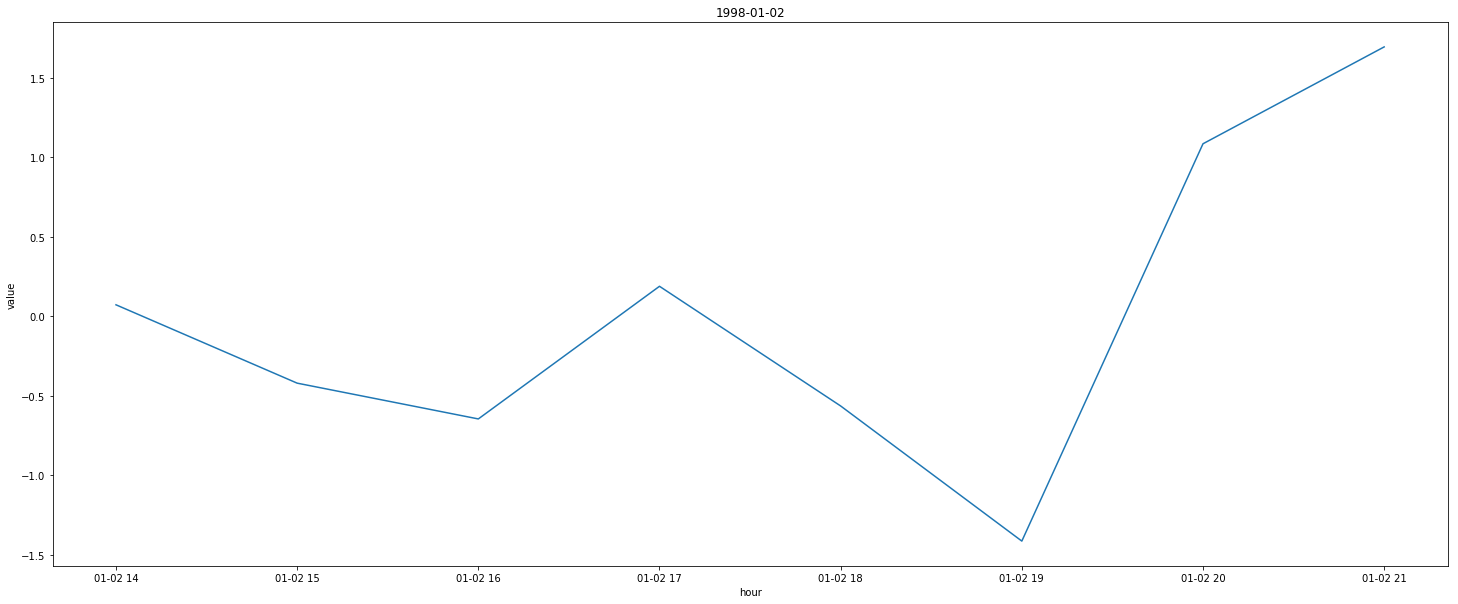

In [27]:
plot_day_ser(normed_dfs['thresh_dzn'].loc[:, 'pba_oc_return_fth_of_xwhole'], '1998-01-02')

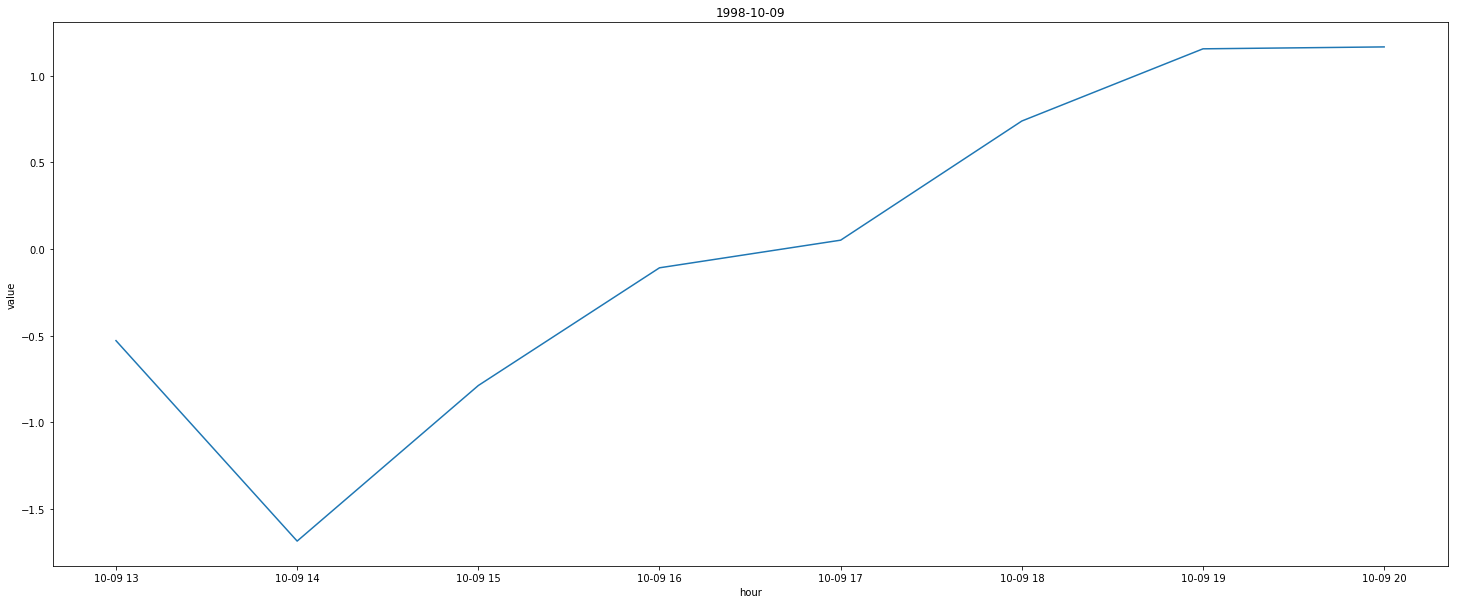

In [30]:
plot_day_ser(normed_dfs['raw_pba_dzn'].loc[:, 'pba_close'].dropna(), '1998-10-09')
# custom = get_custom_biz_freq(ope)
# ope.groupby(pd.Grouper(custom)).transform(lambda ser: )

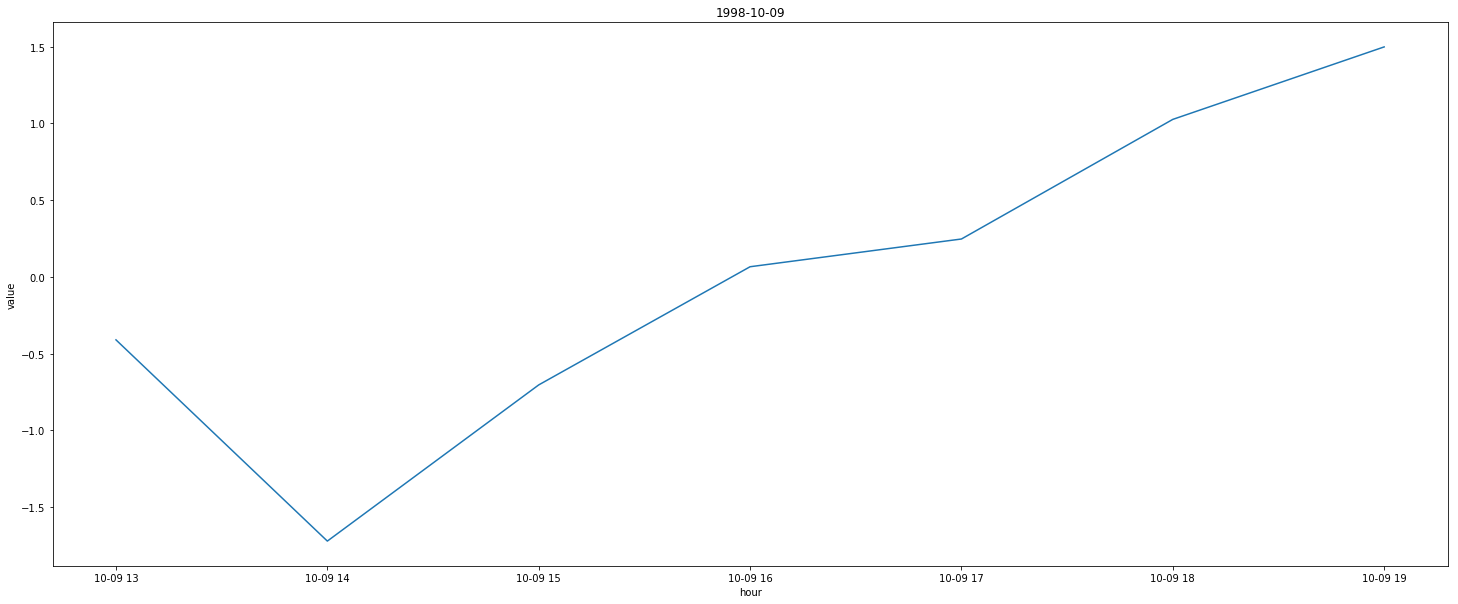

In [40]:
plot_day_ser(dzn_pba_vol_df.loc[:, 'pba_close'].dropna(), '1998-10-09')

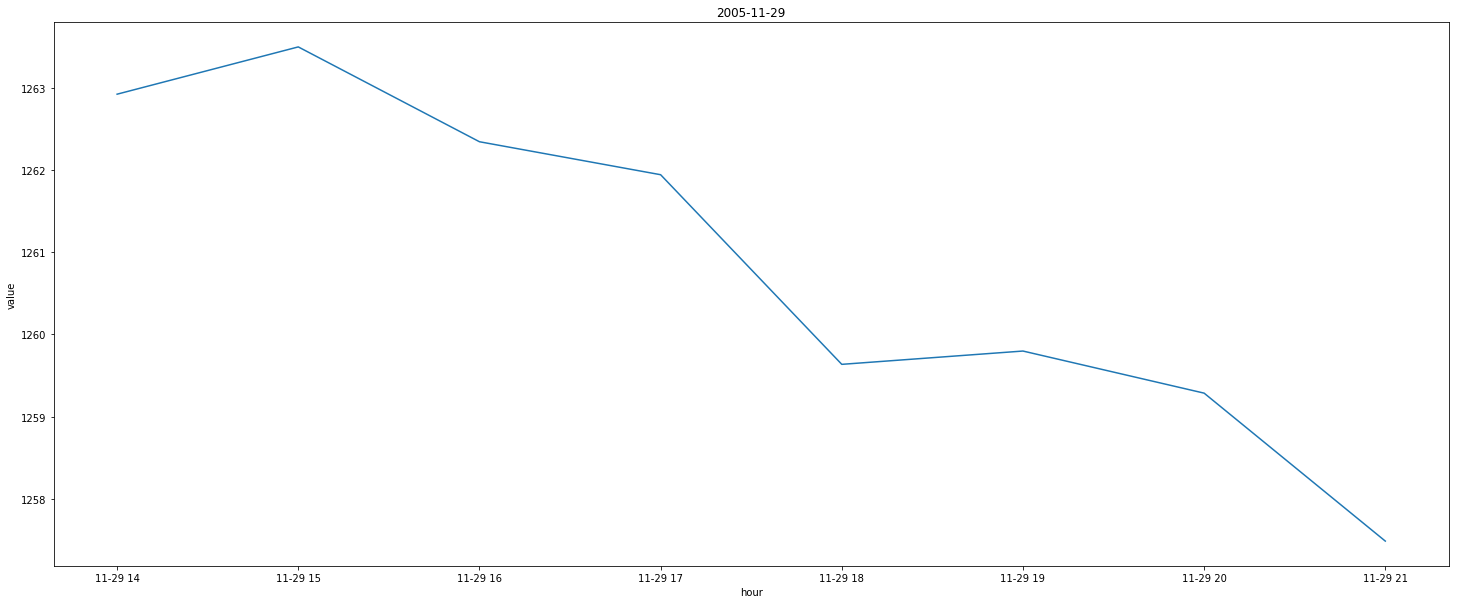

In [26]:
plot_day_ser(price_vol_cols_df.loc[:, 'pba_avgPrice'].dropna(), '2005-11-29')

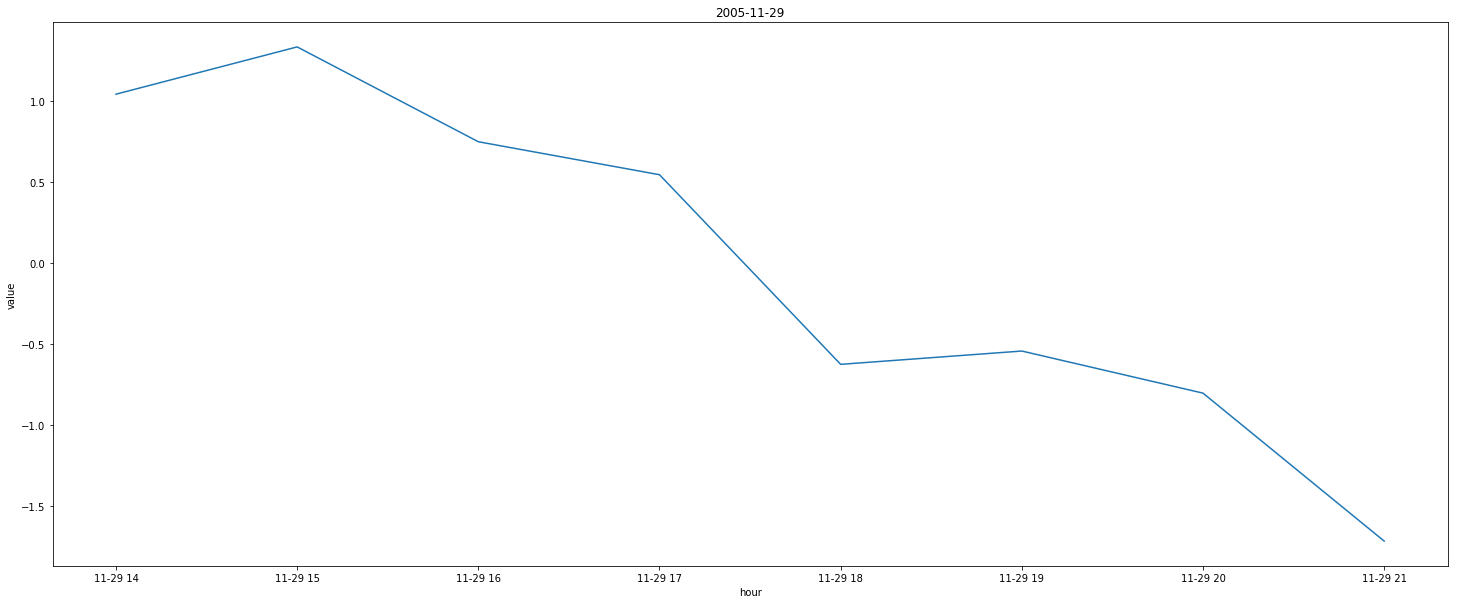

In [21]:
plot_day_ser(dzn_price_vol_cols_df.loc[:, 'pba_avgPrice'].dropna(), '2005-11-29')

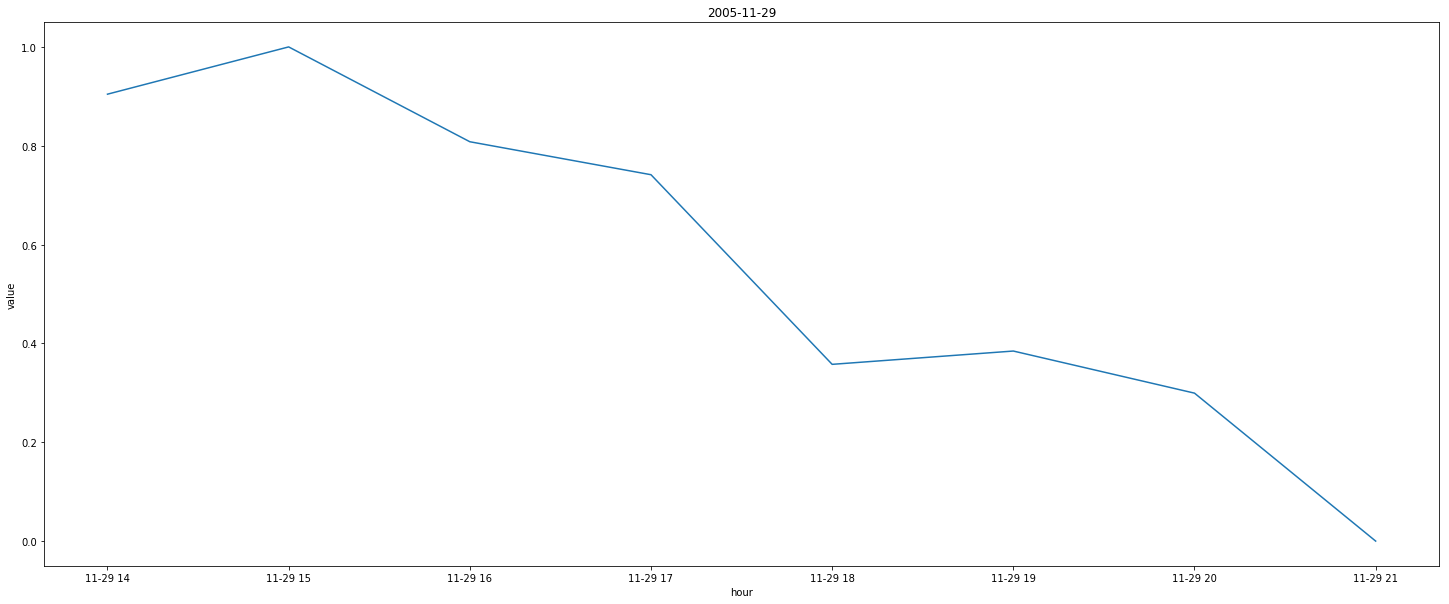

In [22]:
plot_day_ser(dmx_price_vol_cols_df.loc[:, 'pba_avgPrice'].dropna(), '2005-11-29')

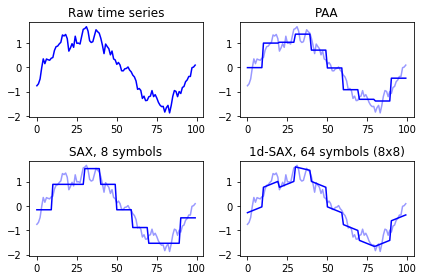

In [70]:
# Author: Romain Tavenard
# License: BSD 3 clause

import numpy
import matplotlib.pyplot as plt

from tslearn.generators import random_walks
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.piecewise import PiecewiseAggregateApproximation
from tslearn.piecewise import SymbolicAggregateApproximation, OneD_SymbolicAggregateApproximation

numpy.random.seed(0)
# Generate a random walk time series
n_ts, sz, d = 1, 100, 1
dataset = random_walks(n_ts=n_ts, sz=sz, d=d)
scaler = TimeSeriesScalerMeanVariance(mu=0., std=1.)  # Rescale time series
dataset = scaler.fit_transform(dataset)

# PAA transform (and inverse transform) of the data
n_paa_segments = 10
paa = PiecewiseAggregateApproximation(n_segments=n_paa_segments)
paa_dataset_inv = paa.inverse_transform(paa.fit_transform(dataset))

# SAX transform
n_sax_symbols = 8
sax = SymbolicAggregateApproximation(n_segments=n_paa_segments, alphabet_size_avg=n_sax_symbols)
sax_dataset_inv = sax.inverse_transform(sax.fit_transform(dataset))

# 1d-SAX transform
n_sax_symbols_avg = 8
n_sax_symbols_slope = 8
one_d_sax = OneD_SymbolicAggregateApproximation(n_segments=n_paa_segments, alphabet_size_avg=n_sax_symbols_avg,
                                                alphabet_size_slope=n_sax_symbols_slope)
one_d_sax_dataset_inv = one_d_sax.inverse_transform(one_d_sax.fit_transform(dataset))

plt.figure()
plt.subplot(2, 2, 1)  # First, raw time series
plt.plot(dataset[0].ravel(), "b-")
plt.title("Raw time series")

plt.subplot(2, 2, 2)  # Second, PAA
plt.plot(dataset[0].ravel(), "b-", alpha=0.4)
plt.plot(paa_dataset_inv[0].ravel(), "b-")
plt.title("PAA")

plt.subplot(2, 2, 3)  # Then SAX
plt.plot(dataset[0].ravel(), "b-", alpha=0.4)
plt.plot(sax_dataset_inv[0].ravel(), "b-")
plt.title("SAX, %d symbols" % n_sax_symbols)

plt.subplot(2, 2, 4)  # Finally, 1d-SAX
plt.plot(dataset[0].ravel(), "b-", alpha=0.4)
plt.plot(one_d_sax_dataset_inv[0].ravel(), "b-")
plt.title("1d-SAX, %d symbols (%dx%d)" % (n_sax_symbols_avg * n_sax_symbols_slope,
                                          n_sax_symbols_avg,
                                          n_sax_symbols_slope))

plt.tight_layout()
plt.show()